In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rc("font",family = "NanumBarunGothic")
# 음수 표시
matplotlib.rc("axes",unicode_minus=False)

In [3]:
# 데이터 불러오기
df_raw = pd.read_csv("/home/piai/22기 최예진/230510/2. Big Data 분석/체질검사.csv",encoding='euc-kr')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER
0,35.2,46,363.15 lb,72.25 inch,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성
1,11.8,27,168 lb,71.25 inch,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성
2,22.2,69,177.75 lb,68.5 inch,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성
3,10.6,57,147.75 lb,65.75 inch,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성
4,47.5,51,219 lb,64 inch,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성


In [4]:
# 결측치 확인
df_raw.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
GENDER     0
dtype: int64

In [5]:
# 단위와 같이 표현되어 있는 수치형 변수 처리
df_raw[['WEIGHT','WEIGHT_UNIT']]=df_raw['WEIGHT'].str.split(expand=True)
df_raw[['HEIGHT','HEIGHT_UNIT']]=df_raw['HEIGHT'].str.split(expand=True)
df_raw['WEIGHT']=df_raw['WEIGHT'].astype('float64')
df_raw['HEIGHT']=df_raw['HEIGHT'].astype('float64')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FAT          252 non-null    float64
 1   AGE          252 non-null    int64  
 2   WEIGHT       252 non-null    float64
 3   HEIGHT       252 non-null    float64
 4   NECK         252 non-null    float64
 5   CHEST        252 non-null    float64
 6   ABDOMEN      252 non-null    float64
 7   HIP          252 non-null    float64
 8   THIGH        252 non-null    float64
 9   KNEE         252 non-null    float64
 10  ANKLE        252 non-null    float64
 11  BICEPS       252 non-null    float64
 12  FOREARM      252 non-null    float64
 13  WRIST        252 non-null    float64
 14  GENDER       252 non-null    object 
 15  WEIGHT_UNIT  252 non-null    object 
 16  HEIGHT_UNIT  252 non-null    object 
dtypes: float64(13), int64(1), object(3)
memory usage: 33.6+ KB


###### : 파일을 불러보니 WEIGHT(몸무게)와 HEIGHT(키)가 단위와 같이 들어있다. -> 단위를 나타내는 항목을 제외시킨다.

In [6]:
#단위를 나타내는 항목 제외
df_raw=df_raw.drop(['WEIGHT_UNIT','HEIGHT_UNIT'],axis=1)

###### : 파생변수(BMI)를 생성하기 위해 bmi 함수를 만들었다.

In [7]:
# bmi 함수 만들기 
def bmi(weight,height):
    height = height*0.0254
    weight = weight*0.45
    
    bmi = weight / (height * height)

    return bmi

# BMI 값 생성
df_raw['BMI']=bmi(df_raw['WEIGHT'],df_raw['HEIGHT'])

In [8]:
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성,48.523870
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성,23.082595
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성,26.422478
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성,23.838617
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성,37.293165


In [9]:
# 파생변수 생성을 위해 사용한 변수 제외
df_raw.drop(['WEIGHT','HEIGHT'],axis=1,inplace=True)

In [10]:
df_raw.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER,BMI
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,남성,48.523870
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,남성,23.082595
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,남성,26.422478
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,여성,23.838617
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,여성,37.293165


###### : 이후 '남성' 혹은 '여성'으로 구분되어 있는 GENDER의 값들을 남성은 0, 여성은 1로 바꿔주었다.

In [11]:
df_raw['GENDER']=df_raw['GENDER'].replace('남성',0)
df_raw['GENDER']=df_raw['GENDER'].replace('여성',1)
df_raw.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER,BMI
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0,48.523870
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0,23.082595
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0,26.422478
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1,23.838617
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1,37.293165


In [12]:
# 범주형 변수의 Dummy 변수화
df_raw_dummy = pd.get_dummies(df_raw,drop_first=True)
df_raw_dummy.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER,BMI
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,0,48.523870
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,0,23.082595
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,0,26.422478
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,1,23.838617
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,1,37.293165


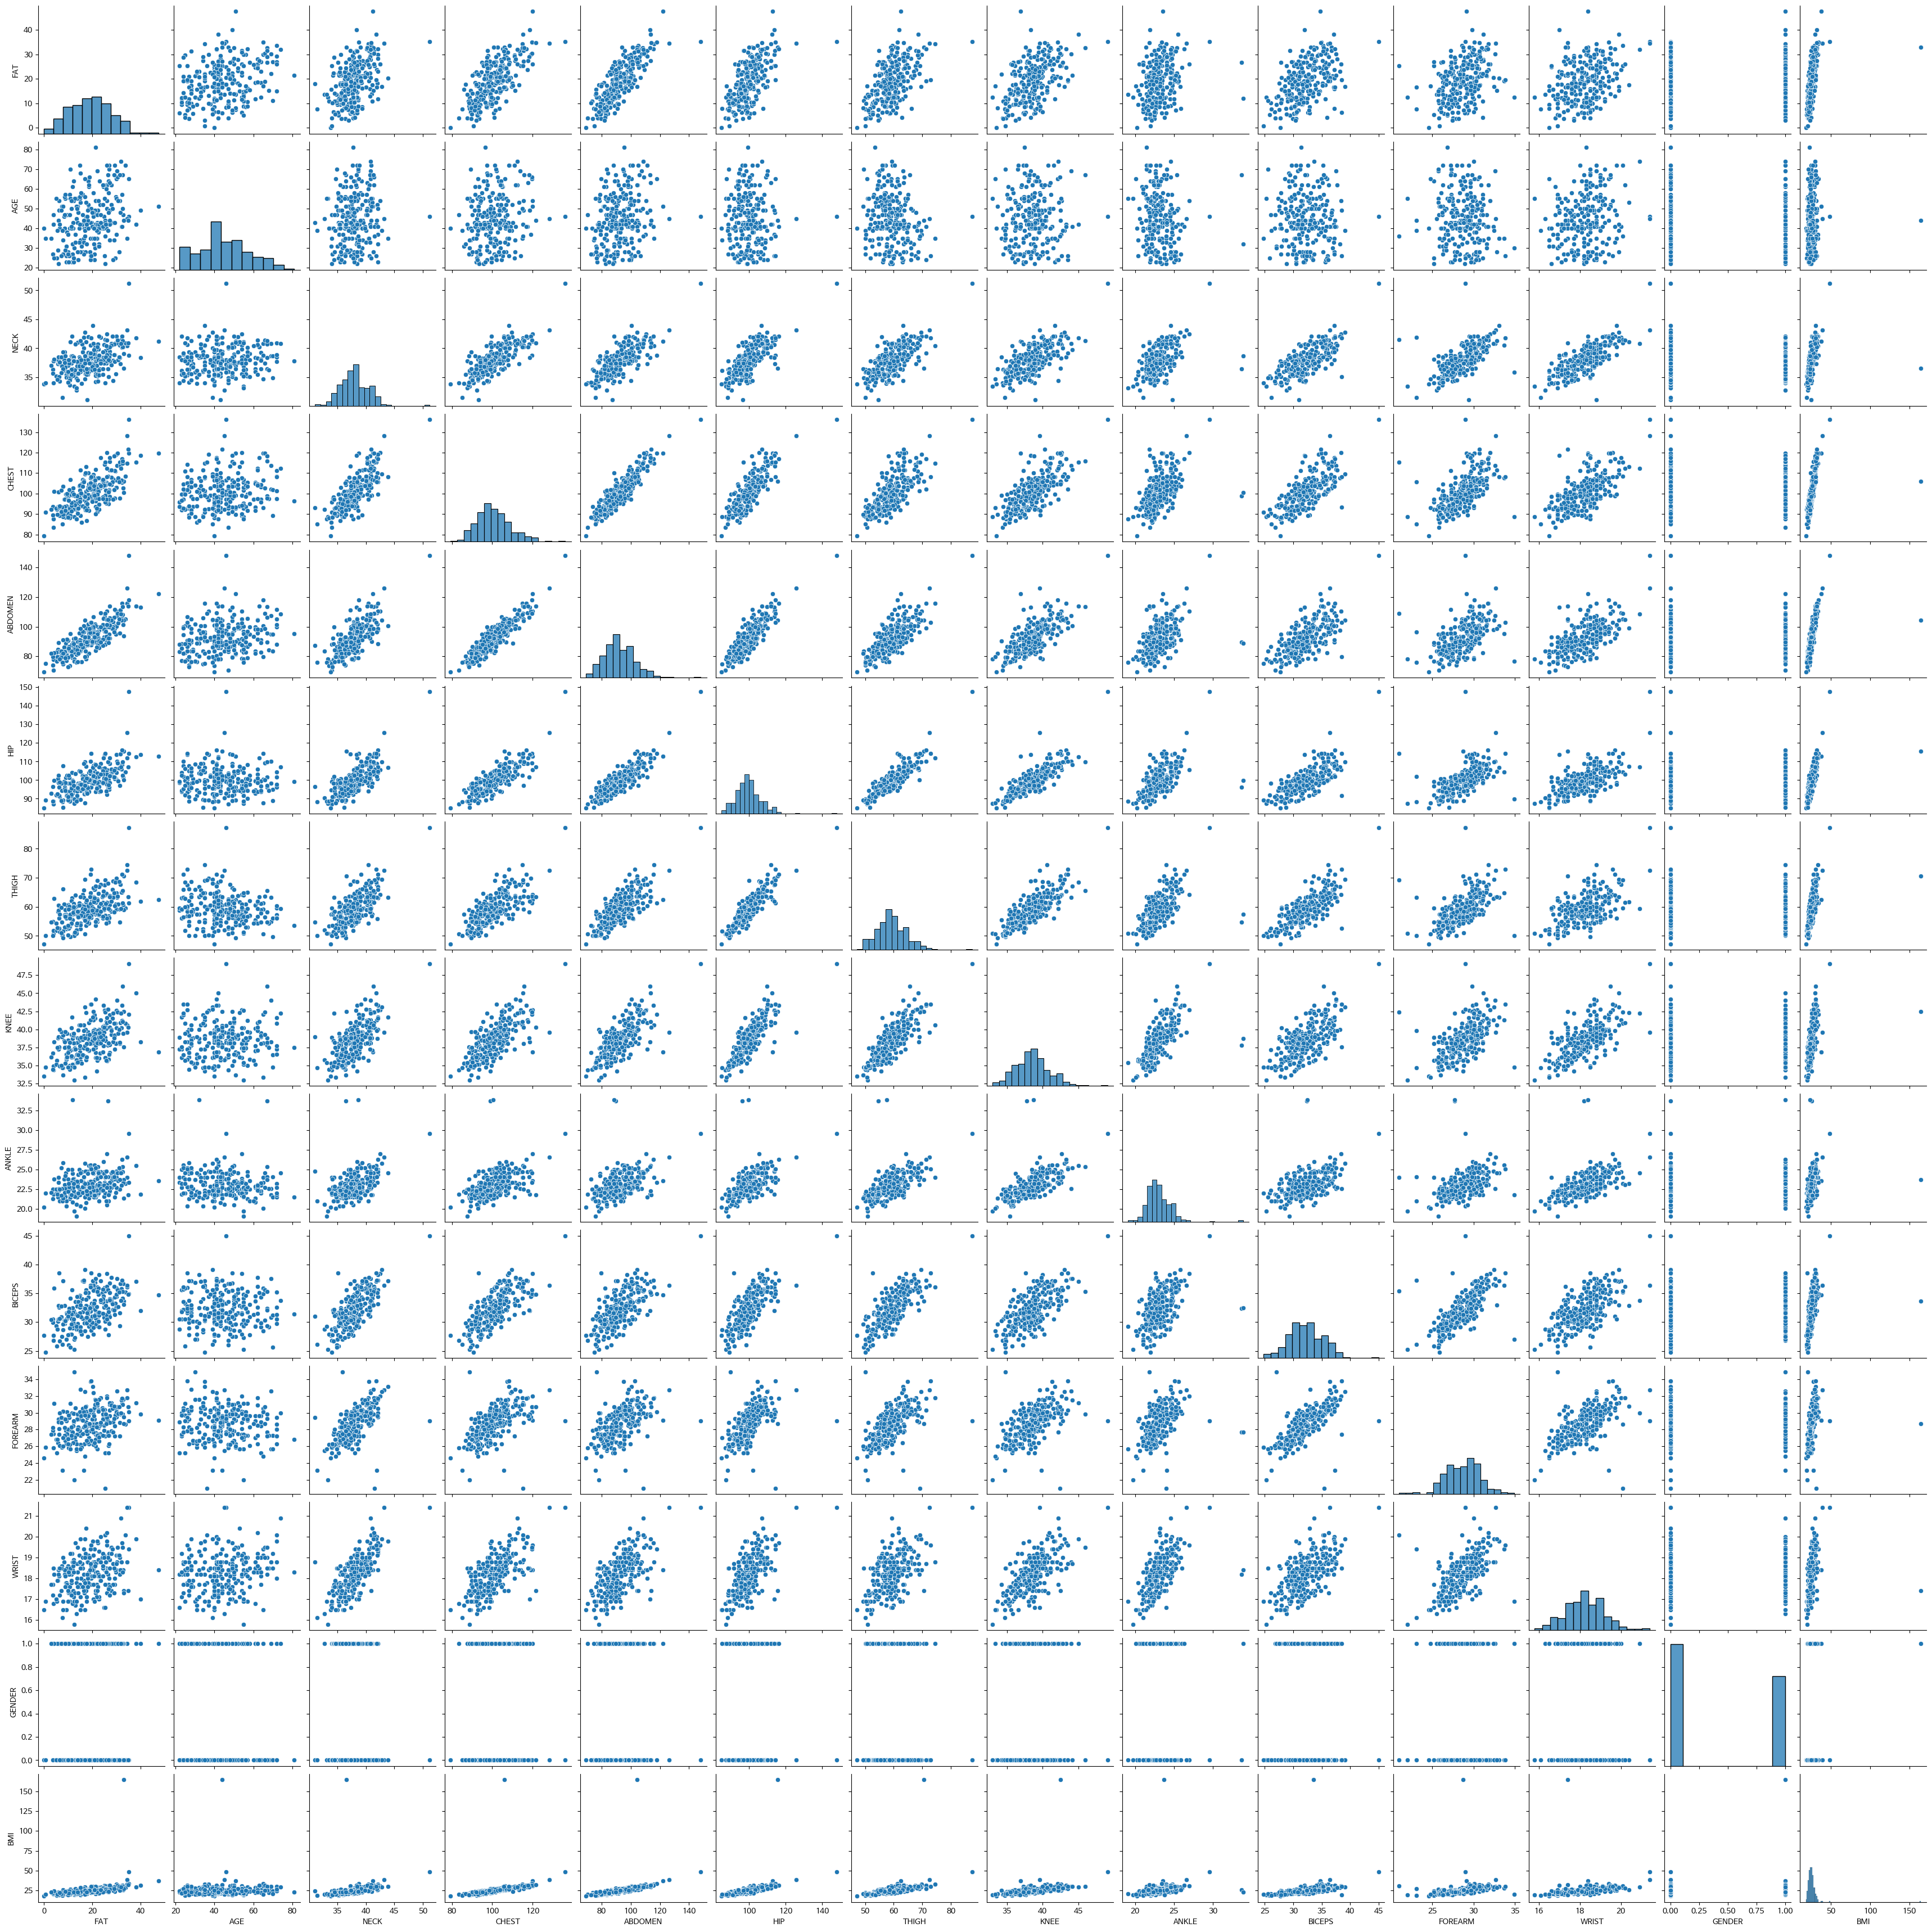

In [13]:
sns.pairplot(df_raw_dummy)

In [14]:
# 상관관계 분석
df_raw_dummy.corr().round(3)

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,GENDER,BMI
FAT,1.000,0.291,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,-0.033,0.371
AGE,0.291,1.000,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,-0.063,0.040
NECK,0.491,0.114,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.010,0.266
CHEST,0.703,0.176,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,-0.014,0.383
ABDOMEN,0.813,0.230,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,-0.017,0.415
HIP,0.625,-0.050,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,-0.042,0.462
THIGH,0.560,-0.200,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,-0.040,0.433
KNEE,0.509,0.018,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,-0.034,0.364
ANKLE,0.266,-0.105,0.478,0.483,0.453,0.558,0.540,0.612,1.000,0.485,0.419,0.566,-0.012,0.210
BICEPS,0.493,-0.041,0.731,0.728,0.685,0.739,0.761,0.679,0.485,1.000,0.678,0.632,0.040,0.311


###### : 위의 산점도 행렬과 상관게수 분석을 확인한 결과 ABDOMEN이 목표변수에 가장 영향이 큰 변수고 그 다음이 CHEST임을 확인할 수 있었다.

In [15]:
df_train,df_test=train_test_split(df_raw_dummy, test_size=0.4, random_state = 100)
print("train data size:{}".format(df_train.shape))
print("test data size:{}".format(df_test.shape))

train data size:(151, 14)
test data size:(101, 14)


###### : Train data와 Test data를 분리한  후 선형회귀분석을 통해 자유도, 결정게수, 회귀계수, 검정 통계량, 유의확률 등을 확인할 수 있었다.

In [16]:
reg_model = smf.ols(formula="FAT~AGE+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+GENDER+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     37.08
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.95e-38
Time:                        21:10:10   Log-Likelihood:                -426.82
No. Observations:                 151   AIC:                             881.6
Df Residuals:                     137   BIC:                             923.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8028      9.789      0.286      0.7

###### : 위의 결과에서 ABDOMEN,HIP의 P값이 유의수준 0.05보다  작으므로 유의한 것을 확인할 수 있었다.

In [17]:
# 설명변수간의 다중공선성 확인
df_train_x=df_train.drop('FAT',axis=1)

df_train_x_const=add_constant(df_train_x)
# DataFrame으로 저장
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
12,GENDER,1.16
13,BMI,1.43
8,ANKLE,1.68
10,FOREARM,1.69
1,AGE,2.20
11,WRIST,3.40
7,KNEE,4.09
2,NECK,4.32
9,BICEPS,4.46
3,CHEST,8.94


###### : 이후 다중공선성을 확인해 본 결과 THIGH, ABODOMEN, HIP 의 VIF값이 10 이상인 것을 확인할 수 있었다.
######   이에 VIF 값이 가장 높은 HIP변수를 제거하기로 했다.

In [18]:
# HIP 제거
reg_model = smf.ols(formula="FAT~AGE+NECK+CHEST+ABDOMEN+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+GENDER+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     35.06
Date:                Mon, 15 May 2023   Prob (F-statistic):           5.00e-36
Time:                        21:10:10   Log-Likelihood:                -435.12
No. Observations:                 151   AIC:                             896.2
Df Residuals:                     138   BIC:                             935.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.6009      9.932     -0.765      0.4

###### : HIP을 삭제하고 난 후 ABDOMEN 이외에 AGE,NECK,FOREARM의 P값이 유의수준 0.05보다 작아져 유의한 것을 확인할 수 있었다.

In [19]:
df_train_x=df_train.drop(['FAT','HIP'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
11,GENDER,1.13
12,BMI,1.35
7,ANKLE,1.63
9,FOREARM,1.68
1,AGE,2.01
10,WRIST,3.20
6,KNEE,4.03
2,NECK,4.30
8,BICEPS,4.46
5,THIGH,8.52


###### : 다시 다중공선성을 확인해 보니 ABDOMEN 외에는 10을 넘는 변수는 없었다. 하지만 위에서 확인했듯이 ABDOMEN은 목표변수에 가장 영향이 큰 변수이므로 제거하지 않는쪽을 선택하였다. 이에 P값이 가장 큰 ANKLE 값을 제거해주었다. 

In [44]:
# ANKLE 제거
reg_model = smf.ols(formula="FAT~AGE+NECK+CHEST+ABDOMEN+THIGH+KNEE+FOREARM+WRIST+GENDER+BMI+BICEPS",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     38.52
Date:                Mon, 15 May 2023   Prob (F-statistic):           7.86e-37
Time:                        21:35:18   Log-Likelihood:                -435.12
No. Observations:                 151   AIC:                             894.2
Df Residuals:                     139   BIC:                             930.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5727      9.890     -0.766      0.4

###### : ANKLE을 삭제하고 난 후 ABDOMEN,AGE,NECK,FOREARM,WRIST의 P값이 유의수준 0.05보다 작아져 유의한 것을 확인할 수 있었다.

In [45]:
df_train_x=df_train.drop(['FAT','HIP','ANKLE'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
10,GENDER,1.13
11,BMI,1.35
8,FOREARM,1.68
1,AGE,1.98
9,WRIST,3.05
6,KNEE,3.81
2,NECK,4.29
7,BICEPS,4.45
5,THIGH,8.52
3,CHEST,8.78


###### : 이후 또다시 다중공선성을 확인해 보니 ABDOMEN 외에는 10을 넘는 변수는 없었다. 하지만 ABDOMEN는 목표변수에 가장 영향이 큰 변수이므로 제거하지 않았고, 이에 P값이 유의수준인 0.05보다 큰 값들을 제거해주었다.
###### (BICEPS,KNEE,NECK,GENDER,FOREARM,THIGH,CHEST 제거)

In [46]:
# BICEPS 제거
reg_model = smf.ols(formula="FAT~AGE+NECK+CHEST+ABDOMEN+THIGH+KNEE+FOREARM+WRIST+GENDER+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     42.59
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.30e-37
Time:                        21:35:33   Log-Likelihood:                -435.24
No. Observations:                 151   AIC:                             892.5
Df Residuals:                     140   BIC:                             925.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9614      9.403     -0.953      0.3

In [47]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
9,GENDER,1.13
10,BMI,1.35
7,FOREARM,1.51
1,AGE,1.97
8,WRIST,3.00
6,KNEE,3.80
2,NECK,4.10
5,THIGH,7.09
3,CHEST,8.65
4,ABDOMEN,10.62


In [24]:
# KNEE 제거
reg_model = smf.ols(formula="FAT~AGE+NECK+CHEST+ABDOMEN+THIGH+FOREARM+WRIST+GENDER+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     47.43
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.34e-38
Time:                        21:10:10   Log-Likelihood:                -435.51
No. Observations:                 151   AIC:                             891.0
Df Residuals:                     141   BIC:                             921.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.0770      8.901     -1.245      0.2

In [25]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
8,GENDER,1.13
9,BMI,1.35
6,FOREARM,1.51
1,AGE,1.97
7,WRIST,2.79
2,NECK,4.10
5,THIGH,5.59
3,CHEST,8.48
4,ABDOMEN,10.33
0,const,596.15


In [26]:
# NECK 제거
reg_model = smf.ols(formula="FAT~AGE+CHEST+ABDOMEN+THIGH+FOREARM+WRIST+GENDER+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     50.88
Date:                Mon, 15 May 2023   Prob (F-statistic):           5.33e-38
Time:                        21:10:10   Log-Likelihood:                -438.59
No. Observations:                 151   AIC:                             895.2
Df Residuals:                     142   BIC:                             922.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.8130      8.978     -1.538      0.1

In [27]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE','NECK'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
7,GENDER,1.11
8,BMI,1.32
5,FOREARM,1.49
1,AGE,1.97
6,WRIST,2.43
4,THIGH,5.49
2,CHEST,8.07
3,ABDOMEN,10.19
0,const,586.54


In [28]:
# GENDER 제거
reg_model = smf.ols(formula="FAT~AGE+CHEST+ABDOMEN+THIGH+FOREARM+WRIST+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     58.51
Date:                Mon, 15 May 2023   Prob (F-statistic):           7.02e-39
Time:                        21:10:10   Log-Likelihood:                -438.64
No. Observations:                 151   AIC:                             893.3
Df Residuals:                     143   BIC:                             917.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.7499      8.948     -1.537      0.1

In [29]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE','NECK','GENDER'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
7,BMI,1.29
5,FOREARM,1.48
1,AGE,1.84
6,WRIST,2.39
4,THIGH,5.14
2,CHEST,8.06
3,ABDOMEN,10.06
0,const,586.24


In [30]:
# FOREARM 제거
reg_model = smf.ols(formula="FAT~AGE+CHEST+ABDOMEN+THIGH+WRIST+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     65.31
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.19e-38
Time:                        21:10:11   Log-Likelihood:                -441.48
No. Observations:                 151   AIC:                             897.0
Df Residuals:                     144   BIC:                             918.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9861      8.736     -0.914      0.3

In [31]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE','NECK','GENDER','FOREARM'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
6,BMI,1.29
1,AGE,1.79
5,WRIST,2.29
4,THIGH,5.13
2,CHEST,7.91
3,ABDOMEN,10.06
0,const,541.98


In [32]:
# THIGH 제거
reg_model = smf.ols(formula="FAT~AGE+CHEST+ABDOMEN+WRIST+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     78.90
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.28e-39
Time:                        21:10:11   Log-Likelihood:                -441.49
No. Observations:                 151   AIC:                             895.0
Df Residuals:                     145   BIC:                             913.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.7739      8.468     -0.918      0.3

In [33]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE','NECK','GENDER','FOREARM','THIGH'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
1,AGE,1.07
5,BMI,1.20
4,WRIST,2.17
3,ABDOMEN,7.59
2,CHEST,7.90
0,const,512.63


In [34]:
# CHEST 제거
reg_model = smf.ols(formula="FAT~AGE+ABDOMEN+WRIST+BMI",data=df_train)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     99.31
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.20e-40
Time:                        21:10:11   Log-Likelihood:                -441.49
No. Observations:                 151   AIC:                             893.0
Df Residuals:                     146   BIC:                             908.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.6937      8.153     -0.944      0.3

In [35]:
df_train_x=df_train.drop(['FAT','HIP','BICEPS','ANKLE','KNEE','NECK','GENDER','FOREARM','THIGH','CHEST'],axis=1)
df_train_x_const=add_constant(df_train_x)
df_vif=pd.DataFrame()
df_vif['variable']=df_train_x_const.columns
df_vif['VIF']=[variance_inflation_factor(df_train_x_const.values,i)\
              for i in range(df_train_x_const.shape[1])]
df_vif.sort_values("VIF",ascending=True).round(2)

,variable,VIF
1,AGE,1.05
4,BMI,1.20
3,WRIST,1.97
2,ABDOMEN,2.24
0,const,478.47


###### : 하나씩 제거한 후 결과를 확인해보니 ABDOMEN의 VIF값도 10 미만으로. 다중곤선성을 해결했다.

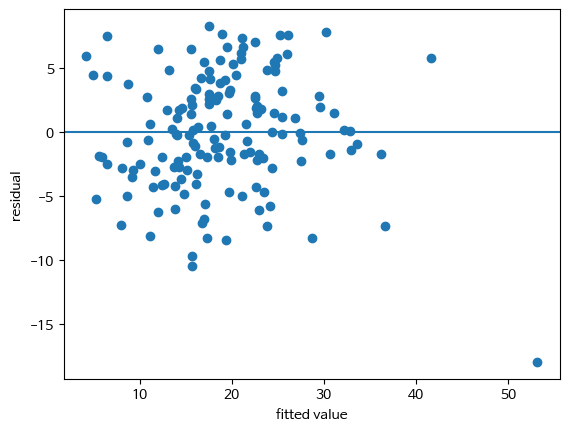

In [36]:
plt.scatter(reg_result.fittedvalues,reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0,linestyle="-")

###### : 등분산성 검정을 통해 확인한 결과 잔차가 Y=0을 기준으로 Random하게 산포되어 잇으므로 등분산성을 만족하는것을 알 수 있다.

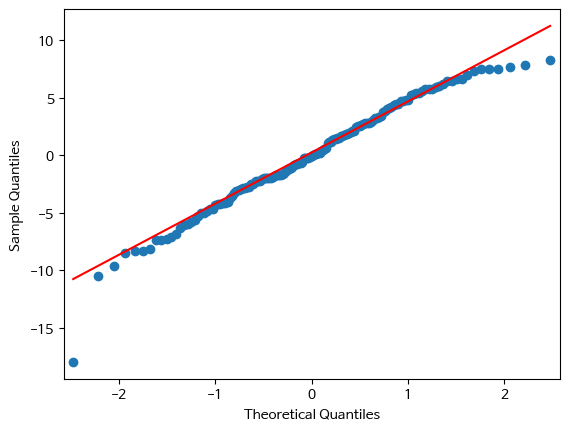

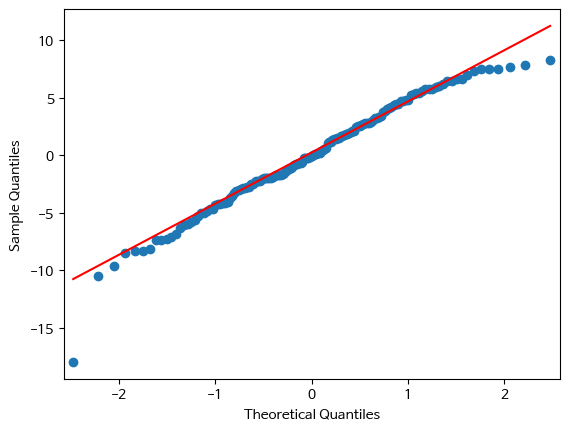

In [37]:
qqplot(reg_result.resid,line="q")

##### : 정규성 검정 또한 정규분포 직선을 중심으로 분포하므로 정규분포를 따르는 것을 알 수 있었다.

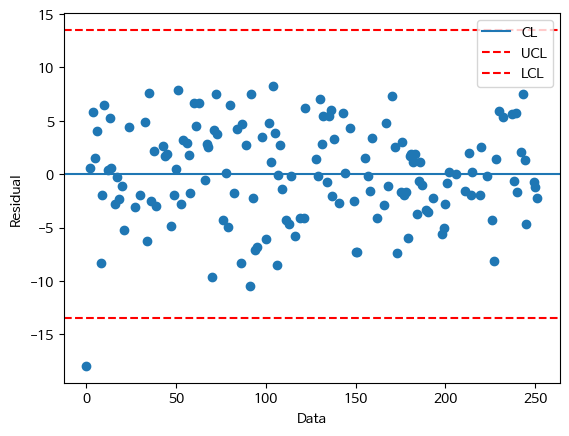

In [38]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data"); plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-",label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label='UCL')
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label='LCL')
plt.legend()

###### : 이후 독립성을 검정해본 결과 잔차가 y=0을 기준으로 관리상하한을 벗어나지 않고, Random하게 산포되어 있으므로 독립성을 만족하는 것을 알 수 있다.

In [39]:
train_pred=reg_result.predict(df_train)
test_pred=reg_result.predict(df_test)
print("train data의 결정계수:",r2_score(df_train['FAT'],train_pred))
print("test data의 결정계수:",r2_score(df_test['FAT'],test_pred))

train data의 결정계수: 0.7312388966927474
test data의 결정계수: 0.6872587278759004


##### : train data의 결정계수는 73.1%, test data의 결정계수는 68.7%로 확인되었다.

<Axes: >

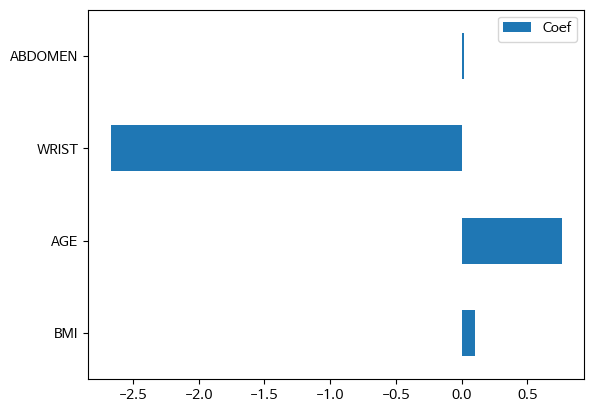

In [41]:
df_reg_coef=pd.DataFrame({"Coef":reg_result.params.values[1:]},
                        index=['BMI','AGE','WRIST','ABDOMEN'])
df_reg_coef.plot.barh(y='Coef')

##### : 중요도는 회귀계수의 절대값 크기이다. 이에 복부 둘레(ABDOMEN)과 나이(AGE), 비만도(BMI)는 커질수록 체질 비만도(FAT)가 높은것을 알 수 있다.